In [1]:
import torch
import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
inputs = torch.load('train_in.pt')
outputs = torch.load('train_out.pt')
np_ins = inputs.numpy()
np_outs = outputs.numpy()

In [3]:
# BASIC STATS #

Output Mean: -0.283
Output Variance: 3.553


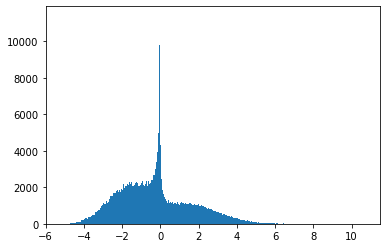

In [4]:
# Outputs
print('Output Mean: %.3f' % torch.mean(outputs))
print('Output Variance: %.3f' % torch.std(outputs)**2)
outputs_histogram = plt.hist(np_outs, 1000)

Input Mean: 0.867
Input Variance: 0.921


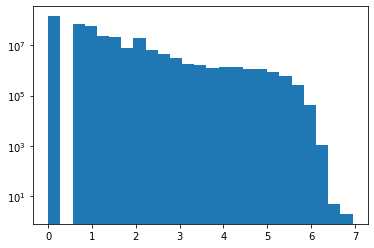

In [5]:
# Inputs

# Overall
print('Input Mean: %.3f' % torch.mean(inputs))
print('Input Variance: %.3f' % torch.std(inputs)**2)
inputs_histogram = plt.hist(np_ins.reshape(-1), 25, log=True)

Histone 1 Input Mean: 0.702
Histone 1 Input Variance: 0.530
Histone 2 Input Mean: 0.708
Histone 2 Input Variance: 0.495
Histone 3 Input Mean: 0.977
Histone 3 Input Variance: 0.675
Histone 4 Input Mean: 1.470
Histone 4 Input Variance: 2.116
Histone 5 Input Mean: 0.502
Histone 5 Input Variance: 0.324


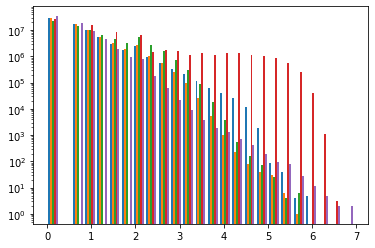

In [6]:
# Per Histone
for i_histone in range(5):
    print('Histone %d Input Mean: %.3f' % (i_histone+1, torch.mean(inputs[:, i_histone])))
    print('Histone %d Input Variance: %.3f' % (i_histone+1, torch.std(inputs[:, i_histone])**2))
histogram = plt.hist([np_ins[:,i].reshape(-1) for i in range(5)], 25, log=True)

Mean:


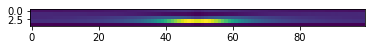

Variance:


In [ ]:
# Per Cell
print('Mean:')
mean_input = plt.imshow(np.mean(np_ins, axis=0))
plt.show()
print('Variance:')
variance_input = plt.imshow(np.std(np_ins, axis=0)**2)
plt.show()
print('This shows that almost all of the "action" is in a very specific region of one histone modification.')

In [ ]:
pos_inds = np_outs > 4
neg_inds = np_outs < -4
pos_examples = np.concatenate([np_ins.reshape(-1, 500)[pos_inds][:200], np_outs[pos_inds][:200].reshape(-1, 1)], axis=1)
neg_examples = np.concatenate([np_ins.reshape(-1, 500)[neg_inds][:200], np_outs[neg_inds][:200].reshape(-1, 1)], axis=1)
plt.imshow(np.concatenate([pos_examples, neg_examples], axis=0))
plt.show()

print('Note how similar the most positive and most negative examples are.')

In [ ]:
nph_ins = np.concatenate([np_ins[:, :3], np_ins[:, 4:]], axis=1)
print(nph_ins.shape)

print('If we take out the dominant histone we get the following:')

In [ ]:
# Overall
print('Input Mean: %.3f' % torch.mean(inputs))
print('Input Variance: %.3f' % torch.std(inputs)**2)
inputs_histogram = plt.hist(nph_ins.reshape(-1), 25, log=True)

In [ ]:
# Per Cell
print('Mean:')
mean_input = plt.imshow(np.mean(nph_ins, axis=0))
plt.show()
print('Variance:')
variance_input = plt.imshow(np.std(nph_ins, axis=0)**2)
plt.show()

In [ ]:
pos_inds = np_outs > 4
neg_inds = np_outs < -4
pos_examples = np.concatenate([nph_ins.reshape(-1, 400)[pos_inds][:200], np_outs[pos_inds][:200].reshape(-1, 1)], axis=1)
neg_examples = np.concatenate([nph_ins.reshape(-1, 400)[neg_inds][:200], np_outs[neg_inds][:200].reshape(-1, 1)], axis=1)
plt.imshow(np.concatenate([pos_examples, neg_examples], axis=0))
plt.show()

In [ ]:
# Per Cell Type
num_cells = 48
cell_samples = inputs.size(0) // num_cells
cells = [(np_ins[i*cell_samples:(i+1)*cell_samples], np_outs[i*cell_samples:(i+1)*cell_samples]) for i in range(num_cells)]
print(cells[-1][0].shape)
print(cells[-1][1].shape)

In [ ]:
for i in range(num_cells):
    print('Output distribution for cell %d' % (i+1))
    plt.hist(cells[i][1], 100)
    plt.show()

In [ ]:
for i in range(num_cells):
    print('Output distribution for cell %d' % (i+1))
    plt.imshow(cells[i][0].mean(axis=0))
    plt.show()

In [ ]:
# How to resample away those peaks??

In [ ]:
print('What if we just resample the dataset according to the square root of the magnitude of the targets?')

i_outs = torch.multinomial(torch.abs(outputs)**(1/2.5), outputs.size(0), replacement=True)
newouts = outputs[i_outs]

print('Output Mean: %.3f' % torch.mean(newouts))
print('Output Variance: %.3f' % torch.std(newouts)**2)
outputs_histogram = plt.hist(newouts, 1000)

print('Eh, not that much better, although it is something.')

In [ ]:
print("Let's say we want to resample our data to be approximately normal:")

centered_outputs = outputs - torch.mean(outputs)
normal_ = torch.randn(outputs.size(0))*1.5
#i_outs = torch.multinomial(outputs, outputs.size(0), replacement=True)
#newouts = outputs[i_outs]

print('Output Mean: %.3f' % torch.mean(centered_outputs))
print('Output Variance: %.3f' % torch.std(centered_outputs)**2)
outputs_histogram = plt.hist(centered_outputs, 1000, (-4.5, 6))
plt.show()

print('Output Mean: %.3f' % torch.mean(normal_))
print('Output Variance: %.3f' % torch.std(normal_)**2)
normal_histogram = plt.hist(normal_, 1000, (-4.5, 6))
plt.show()

In [ ]:
print('To resample to normal we need the transformation distribution between our sample distribution and the normal distribution:')

# normal = adjust x sample
# adjust = normal / sample
new_histogram = normal_histogram[0] / (outputs_histogram[0] + 1e-6)
new_histogram = new_histogram / (np.sum(new_histogram * outputs_histogram[0]) * 0.0105)
plt.plot(normal_histogram[1][:-1], new_histogram)
plt.show()
print(np.sum(new_histogram) * 0.0105)

reconstruction = new_histogram * outputs_histogram[0]
plt.plot(normal_histogram[1][:-1], reconstruction)
plt.show()
print(np.sum(reconstruction) * 0.0105)

In [ ]:
print('To actually perform the resampling, we need to create a pdf over the indices of our dataset such that when sampled it is approximately normal as above:')

# How to use the new histogram to sample from the sample distribution?
# have to line up the outputs for sampling?
logits = centered_outputs
log_ins = inputs
log_ins = log_ins[logits > -4.5]
logits = logits[logits > -4.5]
log_ins = log_ins[logits < 6]
logits = logits[logits < 6]
logits2 = copy.deepcopy(logits)
for idx, edges in enumerate(np.stack([normal_histogram[1][:-1], normal_histogram[1][1:]], axis=1)):
    logits2[(logits >= edges[0]) * (logits <= edges[1])] = new_histogram[idx]

plt.hist(logits2, 100)
plt.show()

'''
Idea:
sort logits, rescale i_outs to be 0 to logits.shape[0] rather than 0 to 1000, and maybe add a little noise
'''

i_outs = torch.multinomial(logits2, outputs.size(0), replacement=True)
plt.hist(i_outs, 100)
plt.show()
#resampled = torch.cat([logits[logits2 == i_out][0:1] for i_out in i_outs])
#i_outs = (i_outs * multiplier + torch.rand(i_outs.shape)*multiplier).long()
resampled = logits[i_outs]
resampled_inputs = log_ins[i_outs]


print('Output Mean: %.3f' % torch.mean(resampled.float()))
print('Output Variance: %.3f' % torch.std(resampled.float())**2)
outputs_histogram = plt.hist(resampled.numpy(), 1000)

In [ ]:
print('Save that resampled data!')

torch.save(resampled, 'resampled_out.pt')
torch.save(resampled_inputs, 'resampled_in.pt')